In [ ]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# import pydicom
# from pydicom import dcmread
from PIL import Image
import cv2
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
# from fast_ml.model_development import train_valid_test_split

In [ ]:
Merged = pd.read_csv('/content/drive/MyDrive/Data/Merged.csv')

In [ ]:
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle competitions download -c rsna-pneumonia-detection-challenge

In [ ]:
# ! unzip rsna-pneumonia-detection-challenge.zip

In [ ]:
# train_labels = pd.read_csv('stage_2_train_labels.csv')
# classInfo = pd.read_csv('stage_2_detailed_class_info.csv')

In [ ]:
# merged = pd.merge(left = classInfo, right = train_labels, how = 'left', on = 'patientId') # Merge
# merged = merged.drop_duplicates() # Remove duplicates

# merged.head()

In [ ]:
# merged = merged.fillna(0)
# merged.head()

In [ ]:
# def get_names(path):
#     names = []
#     for root, dirnames, filenames in os.walk(path):
#         for filename in filenames:
#             _, ext = os.path.splitext(filename)
#             if ext in ['.dcm']:
#                 names.append(filename)
    
#     return names

# def convert_dcm_jpg(name):
    
#     im = pydicom.dcmread('stage_2_train_images/'+name)

#     im = im.pixel_array.astype(float)

#     rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
#     final_image = np.uint8(rescaled_image) # integers pixels

#     final_image = Image.fromarray(final_image)

#     return final_image

In [ ]:
# names = get_names('stage_2_train_images/')
# names
# for name in names:
#     image = convert_dcm_jpg(name)
#     image.save('/content/drive/MyDrive/Colab Notebooks/converted_train_images/'+name+'.jpg')

In [ ]:
# images = os.listdir('/content/drive/MyDrive/Colab Notebooks/converted_train_images')
# images[0]

In [ ]:
# X=[]
# Y=[]
# W=[]
# H=[]
# for i in range(len(train_labels)):
#   x1=Merged['x'][i:i+1]
#   y1=Merged['y'][i:i+1]
#   w1=Merged['width'][i:i+1]
#   h1=Merged['height'][i:i+1]
#   X.append(x1)
#   Y.append(y1)
#   W.append(w1)
#   H.append(h1)

In [ ]:
# X = [int(i) for i in X]
# Y = [int(i) for i in Y]
# W = [int(i) for i in W]
# H = [int(i) for i in H]

In [ ]:
# merged.reset_index(inplace=True)

In [ ]:
# for i in range(Merged.shape[0]):
#   id = Merged['patientId'][i]
#   path = '/content/drive/MyDrive/Colab Notebooks/converted_train_images/'+id+'.dcm.jpg'
#   Merged.at[i,'path']=path

In [ ]:
Merged.head()

,index,patientId,class,x,y,width,height,Target,path,MASK
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0.0,0.0,0.0,0.0,0,/content/drive/MyDrive/Colab Notebooks/convert...,0.0 0.0 0.0 0.0
4,4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,/content/drive/MyDrive/Colab Notebooks/convert...,264.0 152.0 213.0 379.0


In [ ]:
# st=""
# coordinates=[]
# for i in range(len(train_labels)):
#   st = f'{X[i]}' + ',' + f'{Y[i]}' + ',' + f'{X[i]+W[i]}' + ',' + f'{Y[i]+H[i]}'
#   coordinates.append(st)
#   st=""

In [ ]:
# type(coordinates)
# merged.shape

In [ ]:
# for i in range(merged.shape[0]):
#   merged.at[ i , 'mask'] = coordinates[i]

In [ ]:
# from tqdm.notebook import tqdm
# for idx,row in tqdm(merged.iterrows(),total=len(merged)):
#   ls = f"{row['x']} {row['y']} {row['width']} {row['height']}"
#   merged.at[ idx , 'MASK'] = ls

In [ ]:
def extract_coordinates(mergedindex):
  lst=[]
  lst=mergedindex.split(' ',4)
  lst = [int(float(j)) for j in lst]
  return lst

In [ ]:
def create_mask(list1):
  dim = np.zeros((1024,1024,))
  # dim.fill(0)
  # dim[list1[0]:list1[2],list1[1]:list1[3]]=1
  x,y,w,h = list1
  cv2.rectangle(dim,(x,y),(x+w,y+h),(255,0,0),-1)
  return dim

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, IMG_SIZE=None, n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.IMG_SIZE = IMG_SIZE
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.dim = (IMG_SIZE,IMG_SIZE)
        self.on_epoch_end()
        self.mapping = {k:v for k,v in zip(self.list_IDs,self.labels) }

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # print(indexes)
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1), dtype=int)
        
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/converted_train_images/' + ID + '.dcm.jpg')
            # print(cv2.resize(img,(IMG_SIZE,IMG_SIZE)).shape)
            # img = img/255.0
            # cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
            img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            X[i,] = img/img.max()

            # Store class
            coords = self.mapping[ID]
            dic = extract_coordinates(coords)
            mask1 = create_mask(dic)
            y[i] = np.expand_dims(cv2.resize(mask1,(IMG_SIZE,IMG_SIZE)),-1)
        return X,y
    def __repr__(self):
      print("Number of batches: ", str(len(self.list_IDs)/self.batch_size))

In [ ]:
batch_size=4
IMG_SIZE=512
train_gen = DataGenerator(list(Merged.patientId),
                          list(Merged.MASK),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)

train_gen[batch no][X:0><Y:1][ith image in batch(range of i is 0 to 3]



In [ ]:
Train = pd.read_csv('/content/drive/MyDrive/Data/train.csv')
Val = pd.read_csv('/content/drive/MyDrive/Data/valid.csv')

In [ ]:
batch_size=4
IMG_SIZE=512
Train_gen = DataGenerator(list(Train.patientId),
                          list(Train.MASK),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Train_gen))

5289


In [ ]:
# print bar chart of class distribution/percentage

In [ ]:
batch_size=4
IMG_SIZE=512
Val_gen = DataGenerator(list(Val.patientId),
                          list(Val.MASK),
                          batch_size=batch_size,
                          IMG_SIZE=IMG_SIZE,
                          shuffle=True)
print(len(Val_gen))

1133


In [ ]:
# plt.imshow(train_gen[1][0][2][:,:,-1],cmap='gray')
# plt.imshow(train_gen[1][1][2][:,:,-1],cmap='jet',alpha=0.3)

In [ ]:
# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(Merged, target = 'Target', train_size=0.7, valid_size=0.15, test_size=0.15)

In [ ]:
# X_train.reset_index(drop =True,inplace=True)

In [ ]:
# y_train.reset_index(drop =True,inplace=True)
# X_valid.reset_index(drop =True,inplace=True)
# y_valid.reset_index(drop =True,inplace=True)
# X_test.reset_index(drop =True,inplace=True)
# y_test.reset_index(drop =True,inplace=True)

In [ ]:
# X_train.to_csv('/content/drive/MyDrive/Data/X_train.csv')
# y_train.to_csv('/content/drive/MyDrive/Data/y_train.csv')
# X_valid.to_csv('/content/drive/MyDrive/Data/X_valid.csv')
# y_valid.to_csv('/content/drive/MyDrive/Data/y_valid.csv')
# X_test.to_csv('/content/drive/MyDrive/Data/X_test.csv')
# y_test.to_csv('/content/drive/MyDrive/Data/y_test.csv')

In [ ]:
def mask_visualization(data,bno):
  for bi in range(4):
    fig = plt.figure(figsize=(15,10))
    rows=1
    columns=3
    # Xray = cv2.imread(data[bno][0][bi])
    # mask = cv2.imread(data[bno][1][bi])

    fig.add_subplot(rows,columns,1)
    # showing auto
    plt.imshow(data[bno][0][bi][:,:,-1],cmap='gray')
    plt.axis('image')
    plt.title("Xray")

    fig.add_subplot(rows,columns,2)
    # showing auto
    plt.imshow(data[bno][1][bi][:,:,-1],cmap='jet',alpha=0.3)
    plt.axis('image')
    plt.title("Mask")

    fig.add_subplot(rows,columns,3)
    # showing auto
    plt.imshow(data[bno][0][bi][:,:,-1],cmap='gray')
    plt.imshow(data[bno][1][bi][:,:,-1],cmap='jet',alpha=0.3)
    plt.axis('image')
    plt.title("Masked X-Ray")

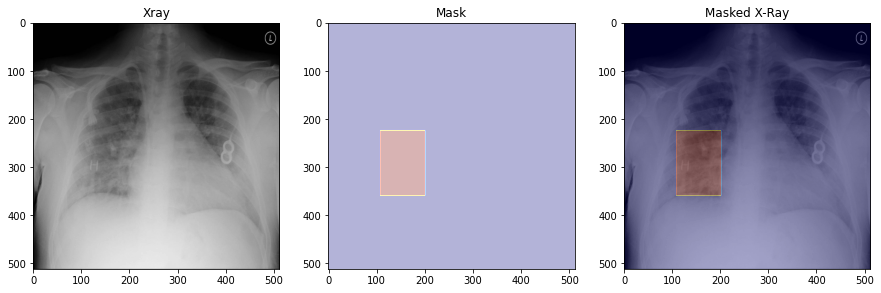

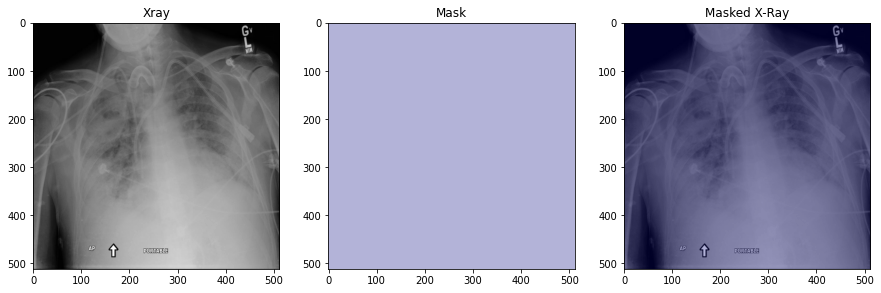

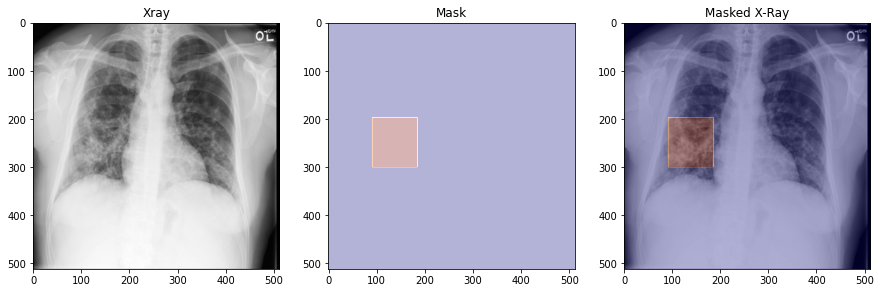

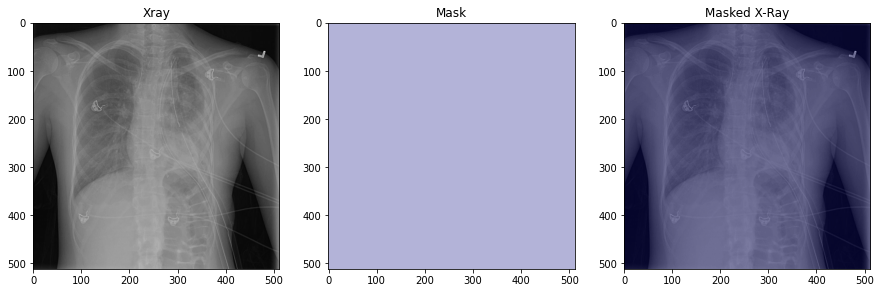

In [ ]:
mask_visualization(Train_gen,11)

In [ ]:
dupId = Merged[Merged.duplicated('patientId')].patientId.unique()[0]

In [ ]:
dupDF = Merged[Merged.patientId == dupId]

In [ ]:
#@title Default title text
fig = plt.figure(figsize=(15,10))
rows=1
columns=3
# Xray = cv2.imread(data[bno][0][bi])
# mask = cv2.imread(data[bno][1][bi])

fig.add_subplot(rows,columns,1)
# showing auto
img = cv2.imread(dupDF.path.iloc[0])
plt.imshow(img,cmap='gray')
plt.axis('image')
plt.title("Xray")

fig.add_subplot(rows,columns,2)
# showing auto
dim = create_mask(extract_coordinates(dupDF.mask.iloc[0]))
plt.imshow(dim,cmap='jet',alpha=0.3)
plt.axis('image')
plt.title("Mask")

fig.add_subplot(rows,columns,3)
# showing auto
plt.imshow(img,cmap='gray')
plt.imshow(dim,cmap='jet',alpha=0.3)
plt.axis('image')
plt.title("Masked X-Ray")

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.0 MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


In [ ]:
model = sm.Unet(backbone_name='inceptionv3',
                         input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         classes=1, activation='sigmoid',
                         weights=None,
                         encoder_weights='imagenet',
                         encoder_freeze=False,
                         encoder_features='default',
                         decoder_block_type='upsampling',
                         decoder_filters=(256, 128, 64, 32, 16),
                         decoder_use_batchnorm=True)

87924736/87910968 [==============================] - 4s 0us/step


In [ ]:
len(model.layers)

352

In [ ]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f1 = K.flatten(K.round(y_pred))
    intersection = K.sum(y_true_f * y_pred_f1)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f1) + smooth)

In [ ]:
smooth = 0.000001
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
def weighted_bce_dice_loss(y_true, y_pred):
    return 0.85*binary_crossentropy(y_true, y_pred) + 0.15*dice_loss(y_true, y_pred)

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001)
model.compile(optimizer = adam, loss = binary_crossentropy , metrics=['accuracy',dice_coef])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

base_model_path = '/content/drive/MyDrive/weights'
model_checkpoint = ModelCheckpoint(
        os.path.join(base_model_path,'Unet_Inception_1_min_val_loss.hdf5'),
        monitor="val_loss", mode='min',save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True, verbose=1)

model_checkpoint_dice = ModelCheckpoint(
        os.path.join(base_model_path,'Unet_Inception_1_max_val_dice.hdf5'),
        monitor="val_dice_coef", mode='max',save_best_only=True, verbose=1)

csv_path = '/content/drive/MyDrive/logs/Unet_Inception_1.csv' 
csv_logger = CSVLogger(csv_path, append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-7)

callbacks = [model_checkpoint, model_checkpoint_dice, reduce_lr, early_stop,csv_logger]

In [ ]:
#TRAINING
if os.path.exists(csv_path):
    os.remove(csv_path)

model.fit(Train_gen,
          validation_data=Val_gen,
          epochs=10,
          verbose=1, 
          callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/10
 246/5289 [>.............................] - ETA: 2:32:50 - loss: -124.4963 - accuracy: 0.3037 - dice_coef: 1.3266

KeyboardInterrupt: ignored